In [1]:
import numpy as np


In [2]:
from PySDM_examples.Toon_et_al_1980_Fig_1 import const
si = const.si


class Setup:
    nt = 10
    dt = 60 * si.s
    mass_of_dry_air = 1
    p0 = 2500 * si.Pa
    q0 = 0
    T0 = 100 * si.K
    w = lambda _, __: 1 * si.km / si.s
    z0 = 0
    n = np.zeros(0)
    volume = np.zeros(0)

setup = Setup()




In [3]:
from PySDM.particles import Particles
from PySDM.physics import formulae as phys
from PySDM.environments._moist import _Moist
from PySDM.environments._moist_lagrangian_parcel import _MoistLagrangianParcel
from PySDM.mesh import Mesh



class MoistLagrangianParcelAdiabaticTITAN(_MoistLagrangianParcel):

    def __init__(self, particles: Particles, dt,
                 mass_of_dry_air: float, p0: float, q0: float, T0: float, w: callable, z0: float = 0, isothermal: bool = False):

        super().__init__(particles, dt, Mesh.mesh_0d(), ['rhod', 'z', 't'], mass_of_dry_air)

        # TODO: move w-related logic to _MoistLagrangianParcel
        self.isothermal = isothermal
        self.w = w

        if q0 == 0:
            pd0 = p0
        else:
            pd0 = p0 * (1 - (1 + const.eps / q0)**-1)

        self['qv'][:] = q0
        self['thd'][:] = phys.th_std(pd0, T0)
        self['rhod'][:] = pd0 / const.Rd / T0
        self['z'][:] = z0
        self['t'][:] = 0

        self.sync_parcel_vars()
        _Moist.sync(self)
        self.notify()

    def advance_parcel_vars(self):
        print("advance")
        dt = self.particles.dt
        qv = self['qv'][0]
        T = self['T'][0]
        p = self['p'][0]
        t = self['t'][0]
        z = self['z'][0]

        rho = p / phys.R(qv) / T
        if qv == 0:
            pd = p
        else:
            pd = p * (1 - 1 / (1 + const.eps / qv))

        # mid-point value for w
        dz_dt = self.w(t + dt/2)

        # Explicit Euler for p,T (predictor step assuming dq=0)
        dp_dt = - rho * const.g(z) * dz_dt
        dpd_dt = dp_dt  # dq=0
        if self.isothermal:
            dT_dt = 0
        else:
            dT_dt = dp_dt / rho / phys.c_p(qv)

        self._tmp['t'][:] += dt
        self._tmp['z'][:] += dt * dz_dt
        self._tmp['rhod'][:] += dt * (
                dpd_dt / const.Rd / T +
                -dT_dt * pd / const.Rd / T**2
        )

In [4]:
from PySDM.particles_builder import ParticlesBuilder
from PySDM.backends import Default
from PySDM.environments.products.pressure import Pressure
from PySDM.environments.products.displacement import Displacement
from PySDM.dynamics.environment import Environment


particles_builder = ParticlesBuilder(n_sd=0, backend=Default)
particles_builder.set_environment(MoistLagrangianParcelAdiabaticTITAN, {
            "dt": setup.dt,
            "mass_of_dry_air": setup.mass_of_dry_air,
            "p0": setup.p0,
            "q0": setup.q0,
            "T0": setup.T0,
            "w": setup.w,
            "z0": setup.z0,
            "isothermal": True
        })
particles_builder.register_dynamic(Environment, {})
attributes = {'n': setup.n, 'volume': setup.volume}
products = {Pressure: {}, Displacement: {}}
particles = particles_builder.get_particles(attributes, products)

C:\Users\Ola\PycharmProjects\PySDM\PySDM\initialisation\multiplicities.py:20: RuntimeWarning: invalid value encountered in double_scalars
  percent_diff = abs(1 - np.sum(y_float) / np.sum(y_int.astype(float)))


In [5]:
z = [setup.z0]
p = [setup.p0]
for i in range(setup.nt):
    particles.run(1)
    p.append(particles.products["p"].get()[0])
    z.append(particles.products['z'].get()[0])

advance
advance
advance
advance
advance
advance
advance
advance
advance
advance


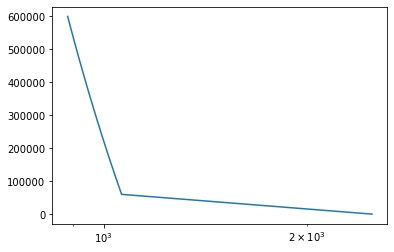

In [6]:
import matplotlib.pyplot as plt
plt.plot(p, z)
#plt.ylim(0, 600000)
#plt.xlim(10**(-4), 10**3)
plt.xscale("log")